# Importing Libraries

In [ ]:
# !pip install emoji
# !pip install pyarabic
# !pip install tashaphyne
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import emoji
import pickle
import seaborn as sns
import os
import numpy as np
import joblib
import arabic_reshaper
from bidi.algorithm import get_display

import warnings
warnings.filterwarnings('ignore')

from textblob import TextBlob
import pickle
import pyarabic.araby as araby
import tashaphyne.arabic_const as arabconst
from tashaphyne.stemming import ArabicLightStemmer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.isri import ISRIStemmer
from nltk.tokenize import TweetTokenizer

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# Loading and Discovering the Dataset

In [ ]:
url = 'https://raw.githubusercontent.com/Hala-Mulki/L-HSAB-First-Arabic-Levantine-HateSpeech-Dataset/master/Dataset/L-HSAB'
data = pd.read_csv(url, sep='\t')

In [ ]:
data.head(10)

,Tweet,Class
0,الوزير جبران باسيل تاج راسك يا جربان ممنوع بعد...,abusive
1,صديقي انت ابن جامعه اللعبه اكبر من داعش اللعبه...,normal
2,و مصلحة لبنان تبدأ باستخراج النفط و الغاز لوقف...,normal
3,وليد جنبلاط كاتب الحكمة يا قذر,abusive
4,شو بتلبقلك كلمة خنزير بتجي مفصله على قياسك وشك...,abusive
5,يا جبران باسيل يا معلم يا ريس يا استاذ بدك حضن...,normal
6,ما سمعنا جعاركم مبارح على القصف الإسرائيلي يلي...,hate
7,نصيحة احكي مع الرئيس ميشال عون او هاجم جبران ب...,normal
8,صافي يا بقر,abusive
9,لا تعتب عليه هيدا اسمه ابو صرماي,abusive


In [ ]:
data.shape

(5846, 2)

In [ ]:
np.unique(data['Class'])

array(['abusive', 'hate', 'normal'], dtype=object)

# Exploratory Data Analysis

### Number of Tweets per Class

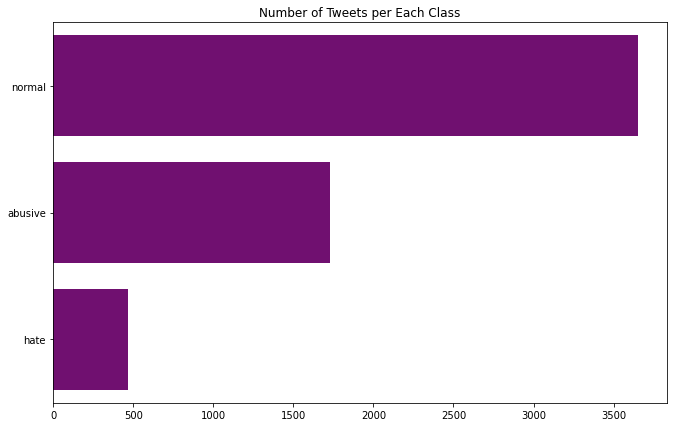

In [ ]:
plt.figure(figsize=(11,7))

ax = sns.countplot(y=data['Class'], data=data, color='purple', order = data['Class'].value_counts().index)

plt.xlabel('')
plt.ylabel('')
plt.title('Number of Tweets per Each Class')

plt.show()

### Word Cloud for the Most Frequent Words

In [ ]:
texts = data['Tweet']
texts = [comment.split(" ") for comment in texts]
texts = [' '.join(comment) for comment in texts]
texts = ' '.join(texts)

reshaped_text = arabic_reshaper.reshape(texts)
bidi_text = get_display(reshaped_text)

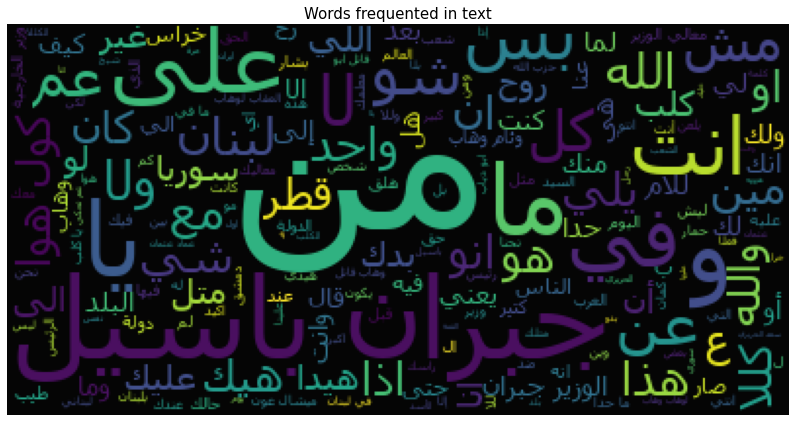

In [ ]:
wordcloud = WordCloud(font_path = 'tahoma.ttf',
                      background_color='black',
                      stopwords=(stops and stop_word_comp),
                      max_words=200, 
                      random_state=42).generate(bidi_text)

plt.figure(figsize=(14,10))
plt.axis("off")
plt.title("Words frequented in text", fontsize=15)
plt.imshow(wordcloud.recolor(colormap= 'viridis' , random_state=42), alpha=0.98)
plt.show()

### Top Unigrams after Removing Stop Words

In [ ]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = stops and stop_word_comp).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(data['Tweet'], 20)

for word, freq in common_words:
    print(word, freq)

df1 = pd.DataFrame(common_words, columns = ['Tweet' , 'count'])

يا 1347
جبران 1080
باسيل 1078
انت 536
بس 384
شو 383
الله 353
عم 331
لبنان 277
مش 244
هوا 204
وهاب 204
كول 194
شي 188
قطر 179
الوزير 170
كلب 163
يلي 157
مين 156
هيك 144


### Top Bigrams after Removing Stop Words

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words = stops and stop_word_comp).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(data['Tweet'], 20)

for word, freq in common_words:
    print(word, freq)

df2 = pd.DataFrame(common_words, columns = ['Tweet' , 'count'])

جبران باسيل 1015
كول هوا 166
الوزير جبران 89
وئام وهاب 61
معالي الوزير 56
وزير الخارجية 53
ميشال عون 49
يا كلب 41
العقاب لوهاب 37
ابو دياب 37
لوهاب وهاب 36
وهاب قاتل 36
قاتل ابو 36
حزب الله 36
عماد عثمان 35
عم تحكي 34
سعد الحريري 32
بلا شرف 28
الخارجية جبران 27
وزير خارجية 27


### Top Trigrams after Removing Stop Words

In [ ]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words = stops and stop_word_comp).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(data['Tweet'], 20)

for word, freq in common_words:
    print(word, freq)

df3 = pd.DataFrame(common_words, columns = ['Tweet' , 'count'])

الوزير جبران باسيل 88
العقاب لوهاب وهاب 36
لوهاب وهاب قاتل 36
وهاب قاتل ابو 36
قاتل ابو دياب 36
الخارجية جبران باسيل 25
وزير خارجية لبنان 21
الرئيس ميشال عون 19
وزير الخارجية جبران 18
يا جبران باسيل 17
التيار الوطني الحر 17
اللبناني جبران باسيل 16
الملك جبران باسيل 16
جبران باسيل بدو 15
وزير الخارجية اللبناني 15
الخارجية اللبناني جبران 15
كول هوا يا 14
يا استاذ وئام 14
يا معالي الوزير 14
يا بلا شرف 13


# Pre-Cleaning Feature Extraction

In [ ]:
# def avg_word(sentence):
#     words = sentence.split()
#     if len(words) == 0:
#         return 0
#     return (sum(len(word) for word in words)/len(words))

# def emoji_counter(sentence):
#     return emoji.emoji_count(sentence)

# data['word_count'] = data['Tweet'].apply(lambda x: len(str(x).split(" ")))
# data['char_count'] = data['Tweet'].str.len() ## this also includes spaces
# data['avg_char_per_word'] = data['Tweet'].apply(lambda x: avg_word(x))
# data['emoji_count'] = data['Tweet'].apply(lambda x: emoji_counter(x))

# data = data.sort_values(by='emoji_count',ascending=[0])
# data.head()

# Data Cleaning and Preprocessing

## Text Normalization

In [ ]:
def normalizeArabic(text):
    text = text.strip()
    text = re.sub("[إأٱآا]", "ا", str(text))
    #text = re.sub("ى", "ي", text)
    #text = re.sub("ؤ", "ء", text)
    #text = re.sub("ئ", "ء", text)
    #text = re.sub("ة", "ه", text)
    noise = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    text = re.sub(noise, '', text)
    text = re.sub(r'(.)\1+', r"\1\1", text)
    return araby.strip_tashkeel(text)

In [ ]:
data['Tweet'] = data['Tweet'].apply(lambda x:normalizeArabic(x))
data.head()

,Tweet,Class
0,الوزير جبران باسيل تاج راسك يا جربان ممنوع بعد...,abusive
1,صديقي انت ابن جامعه اللعبه اكبر من داعش اللعبه...,normal
2,و مصلحة لبنان تبدا باستخراج النفط و الغاز لوقف...,normal
3,وليد جنبلاط كاتب الحكمة يا قذر,abusive
4,شو بتلبقلك كلمة خنزير بتجي مفصله على قياسك وشكلك,abusive


## Removing Stop Words

In [ ]:
stops = set(stopwords.words("arabic"))

stop_word_comp = {"،","آض","آمينَ","آه","آهاً","آي","أ","أب","أجل","أجمع","أخ","أخذ","أصبح","أضحى","أقبل","أقل","أكثر","ألا","أم","أما","أمامك",
                  "أمامكَ","أمسى","أمّا","أن","أنا","أنت","أنتم","أنتما","أنتن","أنتِ","أنشأ","أنّى","أو","أوشك","أولئك","أولئكم",
                  "أولاء","أولالك","أوّهْ","أي","أيا","أين","أينما","أيّ","أَنَّ","أََيُّ","أُفٍّ","إذ","إذا","إذاً","إذما","إذن","إلى",
                  "إليكم","إليكما","إليكنّ","إليكَ","إلَيْكَ","إلّا","إمّا","إن","إنّما","إي","إياك","إياكم","إياكما","إياكن","إيانا","إياه",
                  "إياها","إياهم","إياهما","إياهن","إياي","إيهٍ","إِنَّ","ا","ابتدأ","اثر","اجل","احد","اخرى","اخلولق","اذا","اربعة",
                  "ارتدّ","استحال","اطار","اعادة","اعلنت","اف","اكثر","اكد","الألاء","الألى","الا","الاخيرة","الان","الاول","الاولى",
                  "التى","التي","الثاني","الثانية","الذاتي","الذى","الذي","الذين","السابق","الف","اللائي","اللاتي","اللتان","اللتيا","اللتين",
                  "اللذان","اللذين","اللواتي","الماضي","المقبل","الوقت","الى","اليوم","اما","امام","امس","ان","انبرى","انقلب","انه",
                  "انها","او","اول","اي","ايار","ايام","ايضا","ب","بات","باسم","بان","بخٍ","برس","بسبب","بسّ","بشكل","بضع",
                  "بطآن","بعد","بعض","بك","بكم","بكما","بكن","بل","بلى","بما","بماذا","بمن","بن","بنا","به","بها","بي","بيد",
                  "بين","بَسْ","بَلْهَ","بِئْسَ","تانِ","تانِك","تبدّل","تجاه","تحوّل","تلقاء","تلك","تلكم","تلكما","تم","تينك","تَيْنِ","تِه",
                  "تِي","ثلاثة","ثم","ثمّ","ثمّة","ثُمَّ","جعل","جلل","جميع","جير","حار","حاشا","حاليا","حاي","حتى","حرى","حسب",
                  "حم","حوالى","حول","حيث","حيثما","حين","حيَّ","حَبَّذَا","حَتَّى","حَذارِ","خلا","خلال","دون","دونك","ذا","ذات",
                  "ذاك","ذانك","ذانِ","ذلك","ذلكم","ذلكما","ذلكن","ذو","ذوا","ذواتا","ذواتي","ذيت","ذينك","ذَيْنِ","ذِه","ذِي","راح",
                  "رجع","رويدك","ريث","رُبَّ","زيارة","سبحان","سرعان","سنة","سنوات","سوف","سوى","سَاءَ","سَاءَمَا","شبه","شخصا",
                  "شرع","شَتَّانَ","صار","صباح","صفر","صهٍ","صهْ","ضد","ضمن","طاق","طالما","طفق","طَق","ظلّ","عاد","عام",
                  "عاما","عامة","عدا","عدة","عدد","عدم","عسى","عشر","عشرة","علق","على","عليك","عليه","عليها","علًّ","عن",
                  "عند","عندما","عوض","عين","عَدَسْ","عَمَّا","غدا","غير","ـ","ف","فان","فلان","فو","فى","في","فيم","فيما",
                  "فيه","فيها","قال","قام","قبل","قد","قطّ","قلما","قوة","كأنّما","كأين","كأيّ","كأيّن","كاد","كان","كانت","كذا",
                  "كذلك","كرب","كل","كلا","كلاهما","كلتا","كلم","كليكما","كليهما","كلّما","كلَّا","كم","كما","كي","كيت","كيف",
                  "كيفما","كَأَنَّ","كِخ","لئن","لا","لات","لاسيما","لدن","لدى","لعمر","لقاء","لك","لكم","لكما","لكن","لكنَّما","لكي",
                  "لكيلا","للامم","لم","لما","لمّا","لن","لنا","له","لها","لو","لوكالة","لولا","لوما","لي","لَسْتَ","لَسْتُ","لَسْتُم","لَسْتُمَا",
                  "لَسْتُنَّ","لَسْتِ","لَسْنَ","لَعَلَّ","لَكِنَّ","لَيْتَ","لَيْسَ","لَيْسَا","لَيْسَتَا","لَيْسَتْ","لَيْسُوا","لَِسْنَا","ما","ماانفك","مابرح","مادام",
                  "ماذا","مازال","مافتئ","مايو","متى","مثل","مذ","مساء","مع","معاذ","مقابل","مكانكم","مكانكما","مكانكنّ","مكانَك",
                  "مليار","مليون","مما","ممن","من","منذ","منها","مه","مهما","مَنْ","مِن","نحن","نحو","نعم","نفس","نفسه","نهاية",
                  "نَخْ","نِعِمّا","نِعْمَ","ها","هاؤم","هاكَ","هاهنا","هبّ","هذا","هذه","هكذا","هل","هلمَّ","هلّا","هم","هما","هن","هنا",
                  "هناك","هنالك","هو","هي","هيا","هيت","هيّا","هَؤلاء","هَاتانِ","هَاتَيْنِ","هَاتِه","هَاتِي","هَجْ","هَذا","هَذانِ","هَذَيْنِ","هَذِه",
                  "هَذِي","هَيْهَاتَ","و","و6","وا","واحد","واضاف","واضافت","واكد","وان","واهاً","واوضح","وراءَك","وفي","وقال","وقالت",
                  "وقد","وقف","وكان","وكانت","ولا","ولم","ومن","مَن","وهو","وهي","ويكأنّ","وَيْ","وُشْكَانََ","يكون","يمكن","يوم","ّأيّان"}

In [ ]:
def tokenize_text(text):
    tokens = word_tokenize(text) 
    tokens = [token.strip() for token in tokens]
    return tokens

def remove_stopwords(text):
    tokens = tokenize_text(text)
    filtered_tokens = [token for token in tokens if token not in stops and token not in stop_word_comp]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

In [ ]:
data['Tweet'] = data['Tweet'].apply(lambda x:remove_stopwords(x))
data.head()

,Tweet,Class
0,الوزير جبران باسيل تاج راسك جربان ممنوع المساس...,abusive
1,صديقي انت ابن جامعه اللعبه اكبر داعش اللعبه سن...,normal
2,مصلحة لبنان تبدا باستخراج النفط الغاز لوقف الش...,normal
3,وليد جنبلاط كاتب الحكمة قذر,abusive
4,شو بتلبقلك كلمة خنزير بتجي مفصله قياسك وشكلك,abusive


## Stemming

In [ ]:
# st = ISRIStemmer()

# def stem(text):
#   for token in word_tokenize(text):
#     text = ' '.join(st.stem(token))
#   return text

In [ ]:
# ArListem = ArabicLightStemmer()

# def stem(text):
#     zen = TextBlob(text)
#     words = zen.words
#     cleaned = list()
#     for w in words:
#         ArListem.light_stem(w)
#         cleaned.append(ArListem.get_root())
#     return " ".join(cleaned)

In [ ]:
# data['Tweet'] = data['Tweet'].apply(lambda x:stem(x))
# data.head()

## Removing Emojis

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    return text

In [ ]:
data['Tweet'] = data['Tweet'].apply(lambda x:remove_emoji(x))
data.head()

,Tweet,Class
0,الوزير جبران باسيل تاج راسك جربان ممنوع المساس...,abusive
1,صديقي انت ابن جامعه اللعبه اكبر داعش اللعبه سن...,normal
2,مصلحة لبنان تبدا باستخراج النفط الغاز لوقف الش...,normal
3,وليد جنبلاط كاتب الحكمة قذر,abusive
4,شو بتلبقلك كلمة خنزير بتجي مفصله قياسك وشكلك,abusive


## Text Cleaning

In [ ]:
def clean_text(text):
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)  # remove punctuation
    text = re.sub('\s+', ' ', text)  
    text = re.sub("\d+", " ", text)
    text = re.sub('\W+', ' ', text)
    text = re.sub('[A-Za-z]+',' ',text)
    text = re.sub(r'\\u[A-Za-z0-9\\]+',' ',text)
    text = re.sub('\s+', ' ', text)  
    return text

In [ ]:
data['Tweet'] = data['Tweet'].apply(lambda x:clean_text(x))
data.head()

,Tweet,Class
0,الوزير جبران باسيل تاج راسك جربان ممنوع المساس...,abusive
1,صديقي انت ابن جامعه اللعبه اكبر داعش اللعبه سن...,normal
2,مصلحة لبنان تبدا باستخراج النفط الغاز لوقف الش...,normal
3,وليد جنبلاط كاتب الحكمة قذر,abusive
4,شو بتلبقلك كلمة خنزير بتجي مفصله قياسك وشكلك,abusive


# Splitting the Dataset into Train, Validation, and Test

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(data.Class)
y_encode = le.transform(data.Class)

# le.inverse_transform(y_encode)

In [ ]:
data_df = pd.DataFrame({'Target Label': y_encode, 'Target Name': data.Class, 'Tweet': data.Tweet})

In [ ]:
data_df.head()

,Target Label,Target Name,Tweet
0,0,abusive,الوزير جبران باسيل تاج راسك جربان ممنوع المساس...
1,2,normal,صديقي انت ابن جامعه اللعبه اكبر داعش اللعبه سن...
2,2,normal,مصلحة لبنان تبدا باستخراج النفط الغاز لوقف الش...
3,0,abusive,وليد جنبلاط كاتب الحكمة قذر
4,0,abusive,شو بتلبقلك كلمة خنزير بتجي مفصله قياسك وشكلك


In [ ]:
train_corpus, test_corpus, train_label_nums, test_label_nums, train_label_names, test_label_names = train_test_split(np.array(data_df['Tweet']),
                                                                                                                         np.array(data_df['Target Label']),
                                                                                                                         np.array(data_df['Target Name']),
                                                                                                                         stratify=data_df['Target Label'],
                                                                                                                         test_size=0.15, random_state=42)

train_corpus, valid_corpus, train_label_nums, valid_label_nums, train_label_names, valid_label_names = train_test_split(train_corpus,
                                                                                                                          train_label_nums,
                                                                                                                          train_label_names,
                                                                                                                          stratify=train_label_nums,
                                                                                                                          test_size=0.25, random_state=42)

In [ ]:
print('The Train Corpus has: ', len(train_corpus), ' rows' )
print('The Validation Corpus has: ', len(valid_corpus), ' rows' )
print('The Test Corpus has: ', len(test_corpus), ' rows' )

The Train Corpus has:  3726  rows
The Validation Corpus has:  1243  rows
The Test Corpus has:  877  rows


# Models

### 1. Multinomial Naive Bayes Classifier

In [ ]:
text_mnb = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('mnb', MultinomialNB())])

parameters_mnb = {
    'vect__min_df': [0.1, 0.3, 0.5],
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__max_features': [None, 5000, 10000, 50000],
    'vect__ngram_range': [(1, 1), (1, 2)],  
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2', None],
    'mnb__fit_prior': [True, False],
    'mnb__alpha': [0.00001, 0.0001, 0.001, 0.01, 1],
}

In [ ]:
grid_search_mnb = GridSearchCV(text_mnb, parameters_mnb, n_jobs=-1, cv=5, refit=True)

grid_search_mnb.fit(train_corpus, train_label_names)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('mnb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'mnb__alpha': [1e-05, 0.0001, 0.001, 0.01, 1],
                         'mnb__fit_prior': [True, False],
                         'tfidf__norm': ['l1', 'l2', None],
                         'tfidf__use_idf': [True, False],
                         'vect__max_df': [0.5, 0.75, 1.0],
                         'vect__max_features': [None, 5000, 10000, 50000],
                         'vect__min_df': [0.1, 0.3, 0.5],
                         'vect__ngram_range': [(1, 1), (1, 2)]})

In [ ]:
print("Best score: %0.3f" % grid_search_mnb.best_score_)
print("Best parameters set:")

best_parameters_mnb = grid_search_mnb.best_estimator_.get_params()

for param_name in (parameters_mnb.keys()):
    print("\t%s: %r" % (param_name, best_parameters_mnb[param_name]))

Best score: 0.624
Best parameters set:
	vect__min_df: 0.1
	vect__max_df: 0.5
	vect__max_features: None
	vect__ngram_range: (1, 1)
	tfidf__use_idf: True
	tfidf__norm: 'l1'
	mnb__fit_prior: True
	mnb__alpha: 1e-05


In [ ]:
grid_search_mnb_train = grid_search_mnb.score(train_corpus, train_label_names)
grid_search_mnb_valid = grid_search_mnb.score(valid_corpus, valid_label_names)

In [ ]:
print("Best Multinomial Classifier Train Accuracy: {}".format(grid_search_mnb.score(train_corpus, train_label_names)))
print("Best Multinomial Classifier Valid Accuracy: {}".format(grid_search_mnb.score(valid_corpus, valid_label_names)))

Best Multinomial Classifier Train Accuracy: 0.6242619431025228
Best Multinomial Classifier Valid Accuracy: 0.6242960579243765


### 2. Logistic Regression Classifier

In [ ]:
text_log = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('log', LogisticRegression())])

parameters_log = {
    'vect__min_df': [0.0, 0.1, 0.3, 0.5],
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__max_features': [None, 5000, 10000, 50000],
    'vect__ngram_range': [(1, 1), (1, 2)], 
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2', None],
    'log__solver': ['lbfgs', 'liblinear'], 
    'log__penalty': ['l1', 'l2'], 
    'log__C': [200, 100, 50, 10],
}

In [ ]:
grid_search_log = GridSearchCV(text_log, parameters_log, n_jobs=-1, cv=3, refit=True)

grid_search_log.fit(train_corpus, train_label_names)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('log', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'log__C': [200, 100, 50, 10],
                         'log__penalty': ['l1', 'l2'],
                         'log__solver': ['lbfgs', 'liblinear'],
                         'tfidf__norm': ['l1', 'l2', None],
                         'tfidf__use_idf': [True, False],
                         'vect__max_df': [0.5, 0.75, 1.0],
                         'vect__max_features': [None, 5000, 10000, 50000],
                         'vect__min_df': [0.0, 0.1, 0.3, 0.5],
                         'vect__ngram_range': [(1, 1), (1, 2)]})

In [ ]:
print("Best score: %0.3f" % grid_search_log.best_score_)
print("Best parameters set:")

best_parameters_log = grid_search_log.best_estimator_.get_params()

for param_name in sorted(parameters_log.keys()):
    print("\t%s: %r" % (param_name, best_parameters_log[param_name]))

Best score: 0.779
Best parameters set:
	log__C: 200
	log__penalty: 'l1'
	log__solver: 'liblinear'
	tfidf__norm: None
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__max_features: 50000
	vect__min_df: 0.0
	vect__ngram_range: (1, 1)


In [ ]:
grid_search_log_train = grid_search_log.score(train_corpus, train_label_names)
grid_search_log_valid = grid_search_log.score(valid_corpus, valid_label_names)

In [ ]:
print("Best Logistic Classifier Train Accuracy: {}".format(grid_search_log.score(train_corpus, train_label_names)))
print("Best Logistic Classifier Valid Accuracy: {}".format(grid_search_log.score(valid_corpus, valid_label_names)))

Best Logistic Classifier Train Accuracy: 0.9994632313472893
Best Logistic Classifier Valid Accuracy: 0.7803700724054706


### 3. Reduced Logistic Regression Classifier 

In [ ]:
text_log_reduced = Pipeline([('vect', CountVectorizer(min_df = 0, max_df = 1, max_features = None, ngram_range = (1,2))), 
                             ('tfidf', TfidfTransformer(use_idf = True, norm = None)), ('svd', TruncatedSVD()), ('log', LogisticRegression(C = 50, penalty = 'l1', solver = 'liblinear'))])

parameters_log_reduced = {
    'svd__n_components':[1000, 5000] 
}

In [ ]:
grid_search_log_reduced = GridSearchCV(text_log_reduced, parameters_log_reduced, n_jobs=-1, cv=3, refit=True)

grid_search_log_reduced.fit(train_corpus, train_label_names)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(max_df=1, min_df=0,
                                                        ngram_range=(1, 2))),
                                       ('tfidf', TfidfTransformer(norm=None)),
                                       ('svd', TruncatedSVD()),
                                       ('log',
                                        LogisticRegression(C=50, penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-1, param_grid={'svd__n_components': [1000, 5000]})

In [ ]:
print("Best score: %0.3f" % grid_search_log_reduced.best_score_)
print("Best parameters set:")

best_parameters_log_reduced = grid_search_log_reduced.best_estimator_.get_params()

for param_name in sorted(parameters_log_reduced.keys()):
    print("\t%s: %r" % (param_name, best_parameters_log_reduced[param_name]))

Best score: 0.650
Best parameters set:
	svd__n_components: 5000


In [ ]:
grid_search_reduced_log_train = grid_search_log_reduced.score(train_corpus, train_label_names)
grid_search_reduced_log_valid = grid_search_log_reduced.score(valid_corpus, valid_label_names)

In [ ]:
print("Best Reduced Logistic Classifier Train Accuracy: {}".format(grid_search_log_reduced.score(train_corpus, train_label_names)))
print("Best Reduced Logistic Classifier Valid Accuracy: {}".format(grid_search_log_reduced.score(valid_corpus, valid_label_names)))

Best Reduced Logistic Classifier Train Accuracy: 0.9841653247450349
Best Reduced Logistic Classifier Valid Accuracy: 0.6484312148028962


### 4. Support Vector Machine Classifier

In [ ]:
text_svc = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('svc', SVC())])

parameters_svc = {
    'vect__min_df': [0, 0.1],
    'vect__max_df': [0.5, 1.0],
    #'vect__max_features': [None, 10000, 20000],
    'vect__ngram_range': [(1, 1), (1, 2)],  
    'tfidf__norm': ['l1', 'l2', None],
    #'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__kernel': ['linear', 'rbf'],
    'svc__C': [10, 15, 20],
}

In [ ]:
grid_search_svc = GridSearchCV(text_svc, parameters_svc, n_jobs=-1, cv=3, refit=True)

grid_search_svc.fit(train_corpus, train_label_names)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid={'svc__C': [10, 15, 20],
                         'svc__kernel': ['linear', 'rbf'],
                         'tfidf__norm': ['l1', 'l2', None],
                         'vect__max_df': [0.5, 1.0], 'vect__min_df': [0, 0.1],
                         'vect__ngram_range': [(1, 1), (1, 2)]})

In [ ]:
print("Best score: %0.3f" % grid_search_svc.best_score_)
print("Best parameters set:")

best_parameters_svc = grid_search_svc.best_estimator_.get_params()

for param_name in (parameters_svc.keys()):
    print("\t%s: %r" % (param_name, best_parameters_svc[param_name]))

Best score: 0.769
Best parameters set:
	vect__min_df: 0
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	tfidf__norm: 'l2'
	svc__kernel: 'linear'
	svc__C: 10


In [ ]:
grid_search_svc_train = grid_search_svc.score(train_corpus, train_label_names)
grid_search_svc_valid = grid_search_svc.score(valid_corpus, valid_label_names)

In [ ]:
print("Best SVC Classifier Train Accuracy: {}".format(grid_search_svc.score(train_corpus, train_label_names)))
print("Best SVC Classifier Valid Accuracy: {}".format(grid_search_svc.score(valid_corpus, valid_label_names)))

Best SVC Classifier Train Accuracy: 0.999194847020934
Best SVC Classifier Valid Accuracy: 0.7843925985518906


### 5. Stochastic Gradient Descent Classifier

In [ ]:
text_sgd = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('sgd', SGDClassifier())])

parameters_sgd = {
    'vect__min_df': [0.0, 0.1, 0.3, 0.5],
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__max_features': [None, 10000, 20000, 30000],
    'vect__ngram_range': [(1, 1), (1, 2)], 
    'tfidf__norm': ['l1', 'l2', None],
    'sgd__penalty': ['l2', 'l1', 'elasticnet'], 
    'sgd__alpha': [0.00001, 0.0001, 0.001, 0.1], 
}

In [ ]:
grid_search_sgd = GridSearchCV(text_sgd, parameters_sgd, n_jobs=-1, cv=3, refit=True)

grid_search_sgd.fit(train_corpus, train_label_names)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('sgd', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'sgd__alpha': [1e-05, 0.0001, 0.001, 0.1],
                         'sgd__penalty': ['l2', 'l1', 'elasticnet'],
                         'tfidf__norm': ['l1', 'l2', None],
                         'vect__max_df': [0.5, 0.75, 1.0],
                         'vect__max_features': [None, 10000, 20000, 30000],
                         'vect__min_df': [0.0, 0.1, 0.3, 0.5],
                         'vect__ngram_range': [(1, 1), (1, 2)]})

In [ ]:
print("Best score: %0.3f" % grid_search_sgd.best_score_)
print("Best parameters set:")

best_parameters_sgd = grid_search_sgd.best_estimator_.get_params()

for param_name in sorted(parameters_sgd.keys()):
    print("\t%s: %r" % (param_name, best_parameters_sgd[param_name]))

Best score: 0.773
Best parameters set:
	sgd__alpha: 1e-05
	sgd__penalty: 'l2'
	tfidf__norm: 'l2'
	vect__max_df: 0.5
	vect__max_features: None
	vect__min_df: 0.0
	vect__ngram_range: (1, 2)


In [ ]:
grid_search_sgd_train = grid_search_sgd.score(train_corpus, train_label_names)
grid_search_sgd_valid = grid_search_sgd.score(valid_corpus, valid_label_names)

In [ ]:
print("Best SGD Classifier Train Accuracy: {}".format(grid_search_sgd.score(train_corpus, train_label_names)))
print("Best SGD Classifier Valid Accuracy: {}".format(grid_search_sgd.score(valid_corpus, valid_label_names)))

Best SGD Classifier Train Accuracy: 0.9994632313472893
Best SGD Classifier Valid Accuracy: 0.7819790828640386


### 6. Random Forest Classifier

In [ ]:
text_rfc = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('rfc', RandomForestClassifier())])

parameters_rfc = {
    #'vect__min_df': [0.0, 0.1, 0.3, 0.5],
    #'vect__max_df': [0.5, 0.75, 1.0],
    'vect__ngram_range': [(1, 1), (1, 2)], 
    'tfidf__norm': ['l1', 'l2'],
    'rfc__n_estimators': [50, 100, 500], 
    'rfc__criterion': ['gini', 'entropy'],
    'rfc__max_features': ["auto", "sqrt", "log2"],
    'rfc__bootstrap': [True, False]
}

In [ ]:
grid_search_rfc = GridSearchCV(text_rfc, parameters_rfc, n_jobs=-1, verbose=1, cv=2, refit=True)

grid_search_rfc.fit(train_corpus, train_label_names)

Fitting 2 folds for each of 144 candidates, totalling 288 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('rfc', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rfc__bootstrap': [True, False],
                         'rfc__criterion': ['gini', 'entropy'],
                         'rfc__max_features': ['auto', 'sqrt', 'log2'],
                         'rfc__n_estimators': [50, 100, 500],
                         'tfidf__norm': ['l1', 'l2'],
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [ ]:
print("Best score: %0.3f" % grid_search_rfc.best_score_)
print("Best parameters set:")

best_parameters_rfc = grid_search_rfc.best_estimator_.get_params()

for param_name in sorted(parameters_rfc.keys()):
    print("\t%s: %r" % (param_name, best_parameters_rfc[param_name]))

Best score: 0.750
Best parameters set:
	rfc__bootstrap: False
	rfc__criterion: 'gini'
	rfc__max_features: 'sqrt'
	rfc__n_estimators: 500
	tfidf__norm: 'l2'
	vect__ngram_range: (1, 2)


In [ ]:
grid_search_rfc_train = grid_search_rfc.score(train_corpus, train_label_names)
grid_search_rfc_valid = grid_search_rfc.score(valid_corpus, valid_label_names)

In [ ]:
print("Best Random Forest Classifier Train Accuracy: {}".format(grid_search_rfc.score(train_corpus, train_label_names)))
print("Best Random Forest Classifier Valid Accuracy: {}".format(grid_search_rfc.score(valid_corpus, valid_label_names)))

Best Random Forest Classifier Train Accuracy: 0.9994632313472893
Best Random Forest Classifier Valid Accuracy: 0.7546259050683829


### 7. K-Nearest Neighbors Classifier

In [ ]:
text_knn = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('knn', KNeighborsClassifier())])

parameters_knn = {
    'vect__min_df': [0, 0.1, 0.5],
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__max_features': [None, 10000, 50000],
    'vect__ngram_range': [(1, 1), (1, 2)],  
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2', None],
    'knn__n_neighbors': [10,20, 50, 100],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

In [ ]:
grid_search_knn = GridSearchCV(text_knn, parameters_knn, n_jobs=-1, verbose=1, cv=3, refit=True)

grid_search_knn.fit(train_corpus, train_label_names)

Fitting 3 folds for each of 5184 candidates, totalling 15552 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'knn__n_neighbors': [10, 20, 50, 100],
                         'tfidf__norm': ['l1', 'l2', None],
                         'tfidf__use_idf': [True, False],
                         'vect__max_df': [0.5, 0.75, 1.0],
                         'vect__max_features': [None, 10000, 50000],
                         'vect__min_df': [0, 0.1, 0.5],
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [ ]:
print("Best score: %0.3f" % grid_search_knn.best_score_)
print("Best parameters set:")

best_parameters_knn = grid_search_knn.best_estimator_.get_params()

for param_name in sorted(parameters_knn.keys()):
    print("\t%s: %r" % (param_name, best_parameters_knn[param_name]))

Best score: 0.746
Best parameters set:
	knn__algorithm: 'auto'
	knn__n_neighbors: 20
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.5
	vect__max_features: None
	vect__min_df: 0
	vect__ngram_range: (1, 2)


In [ ]:
grid_search_knn_train = grid_search_knn.score(train_corpus, train_label_names)
grid_search_knn_valid = grid_search_knn.score(valid_corpus, valid_label_names)

In [ ]:
print("Best KNN Classifier Train Accuracy: {}".format(grid_search_knn.score(train_corpus, train_label_names)))
print("Best KNN Classifier Valid Accuracy: {}".format(grid_search_knn.score(valid_corpus, valid_label_names)))

Best KNN Classifier Train Accuracy: 0.773215244229737
Best KNN Classifier Valid Accuracy: 0.7312952534191473


### 8. Ada Boosting Classifier

In [ ]:
text_ada = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('ada', AdaBoostClassifier())])

parameters_ada = {
    #'vect__min_df': [0.0, 0.1, 0.3, 0.5],
    #'vect__max_df': [0.5, 0.75, 1.0],
    'vect__ngram_range': [(1, 1), (1, 2)],  
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2', None],
    'ada__n_estimators': [100, 200, 500],
    'ada__learning_rate': [0.001, 0.01, 0.1, 1, 10],
    'ada__algorithm': ['SAMME', 'SAMME.R']
}

In [ ]:
grid_search_ada = GridSearchCV(text_ada, parameters_ada, n_jobs=-1, verbose=1, cv=3, refit=True)

grid_search_ada.fit(train_corpus, train_label_names)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('ada', AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'ada__algorithm': ['SAMME', 'SAMME.R'],
                         'ada__learning_rate': [0.001, 0.01, 0.1, 1, 10],
                         'ada__n_estimators': [100, 200, 500],
                         'tfidf__norm': ['l1', 'l2', None],
                         'tfidf__use_idf': [True, False],
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [ ]:
print("Best score: %0.3f" % grid_search_ada.best_score_)
print("Best parameters set:")

best_parameters_ada = grid_search_ada.best_estimator_.get_params()

for param_name in sorted(parameters_ada.keys()):
    print("\t%s: %r" % (param_name, best_parameters_ada[param_name]))

Best score: 0.720
Best parameters set:
	ada__algorithm: 'SAMME.R'
	ada__learning_rate: 0.1
	ada__n_estimators: 500
	tfidf__norm: 'l1'
	tfidf__use_idf: False
	vect__ngram_range: (1, 2)


In [ ]:
grid_search_ada_train = grid_search_ada.score(train_corpus, train_label_names)
grid_search_ada_valid = grid_search_ada.score(valid_corpus, valid_label_names)

In [ ]:
print("Best Ada Boost Classifier Train Accuracy: {}".format(grid_search_ada.score(train_corpus, train_label_names)))
print("Best Ada Boost Classifier Valid Accuracy: {}".format(grid_search_ada.score(valid_corpus, valid_label_names)))

Best ADA Classifier Train Accuracy: 0.7399355877616747
Best ADA Classifier Valid Accuracy: 0.7288817377312953


### 9. Gaussin Naive Bayes Classifier

In [ ]:
text_gnb = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), 
                     ('ftf', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), ('gnb', GaussianNB())])

parameters_gnb = {
    'vect__min_df': [0.0, 0.1, 0.3, 0.5],
    'vect__max_df': [0.5, 0.75, 1.0],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__max_features': [None, 10000, 50000],
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2', None],
}

In [ ]:
grid_search_gnb = GridSearchCV(text_gnb, parameters_gnb, n_jobs=-1, verbose=1, cv=3, refit=True)

grid_search_gnb.fit(train_corpus, train_label_names)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('ftf',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x000002ACE9DC3CA0>)),
                                       ('gnb', GaussianNB())]),
             n_jobs=-1,
             param_grid={'tfidf__norm': ['l1', 'l2', None],
                         'tfidf__use_idf': [True, False],
                         'vect__max_df': [0.5, 0.75, 1.0],
                         'vect__max_features': [None, 10000, 50000],
                         'vect__min_df': [0.0, 0.1, 0.3, 0.5],
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [ ]:
print("Best score: %0.3f" % grid_search_gnb.best_score_)
print("Best parameters set:")

best_parameters_gnb = grid_search_gnb.best_estimator_.get_params()

for param_name in sorted(parameters_gnb.keys()):
    print("\t%s: %r" % (param_name, best_parameters_gnb[param_name]))

Best score: 0.627
Best parameters set:
	tfidf__norm: 'l1'
	tfidf__use_idf: False
	vect__max_df: 0.5
	vect__max_features: None
	vect__min_df: 0.0
	vect__ngram_range: (1, 2)


In [ ]:
grid_search_gnb_train = grid_search_gnb.score(train_corpus, train_label_names)
grid_search_gnb_valid = grid_search_gnb.score(valid_corpus, valid_label_names)

In [ ]:
print("Best Gaussian Naive Bayes Classifier Train Accuracy: {}".format(grid_search_gnb.score(train_corpus, train_label_names)))
print("Best Gaussian Naive Bayes Classifier Valid Accuracy: {}".format(grid_search_gnb.score(valid_corpus, valid_label_names)))

Best Gaussian Naive Bayes Classifier Train Accuracy: 0.9951690821256038
Best Gaussian Naive Bayes Classifier Valid Accuracy: 0.6580852775543041


### 10. Gradient Boosting Classifier

In [ ]:
text_grd = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('grd', GradientBoostingClassifier())])

parameters_grd = {
    #'vect__min_df': [0.0, 0.1],
    #'vect__max_df': [0.5, 1.0],
    'vect__ngram_range': [(1, 1), (1, 2)],  
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'grd__n_estimators': [100, 200, 500],
    'grd__learning_rate': [0.001, 0.01, 0.1],
    'grd__loss': ['deviance', 'exponential']
}

In [ ]:
grid_search_grd = GridSearchCV(text_grd, parameters_grd, n_jobs=-1, verbose=1, cv=3, refit=True)

grid_search_grd.fit(train_corpus, train_label_names)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('grd', GradientBoostingClassifier())]),
             n_jobs=-1,
             param_grid={'grd__learning_rate': [0.001, 0.01, 0.1],
                         'grd__loss': ['deviance', 'exponential'],
                         'grd__n_estimators': [100, 200, 500],
                         'tfidf__norm': ['l1', 'l2'],
                         'tfidf__use_idf': [True, False],
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             verbose=1)

In [ ]:
print("Best score: %0.3f" % grid_search_grd.best_score_)
print("Best parameters set:")

best_parameters_grd = grid_search_grd.best_estimator_.get_params()

for param_name in sorted(parameters_grd.keys()):
    print("\t%s: %r" % (param_name, best_parameters_grd[param_name]))

Best score: 0.756
Best parameters set:
	grd__learning_rate: 0.1
	grd__loss: 'deviance'
	grd__n_estimators: 500
	tfidf__norm: 'l1'
	tfidf__use_idf: False
	vect__ngram_range: (1, 1)


In [ ]:
grid_search_grd_train = grid_search_grd.score(train_corpus, train_label_names)
grid_search_grd_valid = grid_search_grd.score(valid_corpus, valid_label_names)

In [ ]:
print("Best Gradient Boost Classifier Train Accuracy: {}".format(grid_search_grd.score(train_corpus, train_label_names)))
print("Best Gradient Boost Classifier Valid Accuracy: {}".format(grid_search_grd.score(valid_corpus, valid_label_names)))

Best Gradient Boost Classifier Train Accuracy: 0.9130434782608695
Best Gradient Boost Classifier Valid Accuracy: 0.7594529364440868


### 11. Voting Classifier 

In [ ]:
text_voting = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('voting', VotingClassifier
                    (estimators=[('log', LogisticRegression(C=200, penalty='l1', solver='liblinear')), 
                                 ('svc', SVC(kernel='linear', C=10)), 
                                 ('sgd', SGDClassifier(alpha=0.00001, penalty='l2')), 
                                 ('grd', GradientBoostingClassifier(learning_rate=0.1, loss='deviance', n_estimators=500)), 
                                 ('rfc', RandomForestClassifier(bootstrap=False, criterion = 'gini', max_features='sqrt'))]))])

parameters_voting = {
    'vect__min_df': [0.0, 0.1, 0.2],
    'vect__max_df': [0.5, 0.75, 1],
    'vect__ngram_range': [(1, 1), (1, 2)],  
    'tfidf__use_idf': [True, False],
    'tfidf__norm': ['l1', 'l2'],
    'voting__voting': ['hard', 'soft']
}

In [ ]:
grid_search_voting = GridSearchCV(text_voting, parameters_voting, n_jobs=-1, verbose=1, cv=3, refit=True)

grid_search_voting.fit(train_corpus, train_label_names)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('voting',
                                        VotingClassifier(estimators=[('log',
                                                                      LogisticRegression(C=200,
                                                                                         penalty='l1',
                                                                                         solver='liblinear')),
                                                                     ('svc',
                                                                      SVC(C=10,
                                                                          kernel='linear')),
                                                                     ('sgd',
                                                                      SGDClassi

In [ ]:
print("Best score: %0.3f" % grid_search_voting.best_score_)
print("Best parameters set:")

best_parameters_voting = grid_search_voting.best_estimator_.get_params()

for param_name in sorted(parameters_voting.keys()):
    print("\t%s: %r" % (param_name, best_parameters_voting[param_name]))

Best score: 0.776
Best parameters set:
	tfidf__norm: 'l2'
	tfidf__use_idf: True
	vect__max_df: 0.75
	vect__min_df: 0.0
	vect__ngram_range: (1, 2)
	voting__voting: 'hard'


In [ ]:
grid_search_voting_train = grid_search_voting.score(train_corpus, train_label_names)
grid_search_voting_valid = grid_search_voting.score(valid_corpus, valid_label_names)

In [ ]:
print("Best Voting Classifier Train Accuracy: {}".format(grid_search_voting.score(train_corpus, train_label_names)))
print("Best Voting Classifier Valid Accuracy: {}".format(grid_search_voting.score(valid_corpus, valid_label_names)))

Best Voting Classifier Train Accuracy: 0.9994632313472893
Best Voting Classifier Valid Accuracy: 0.7892196299275945


# Scores

In [ ]:
models_scores = pd.DataFrame([['Multinomial Naive Bayes', grid_search_mnb_train, grid_search_mnb_valid,],  
                              ['Gaussian Naive Bayes', grid_search_gnb_train, grid_search_gnb_valid,],
                              ['Logitic Regression', grid_search_log_train, grid_search_log_valid,],
                              ['Reduced Logistic Regression', grid_search_reduced_log_train, grid_search_reduced_log_valid,], 
                              ['K-Neighrest Neighbors', grid_search_knn_train, grid_search_knn_valid,],
                              ['Support Vector Classifier', grid_search_svc_train, grid_search_svc_valid,],
                              ['Stochastic Gradient Descent', grid_search_sgd_train, grid_search_sgd_valid,],
                              ['Random Foreset Classifier', grid_search_rfc_train, grid_search_rfc_valid,],
                              ['Ada Boosting Classifier', grid_search_ada_train, grid_search_ada_valid,],
                              ['Gradient Boosting Classifier', grid_search_grd_train, grid_search_grd_valid,],
                              ['Voting Classifier', grid_search_voting_train, grid_search_voting_valid,]],
                columns=['Model', 'Train Score (TF)', 'Validation Score (TF)'])

In [ ]:
models_scores

,Model,Train Score (TF),Validation Score (TF)
0,Multinomial Naive Bayes,0.624262,0.624296
1,Gaussian Naive Bayes,0.995169,0.658085
2,Logitic Regression,0.999463,0.780370
3,Reduced Logistic Regression,0.984165,0.648431
4,K-Neighrest Neighbors,0.773215,0.731295
5,Support Vector Classifier,0.999195,0.784393
6,Stochastic Gradient Descent,0.999463,0.781979
7,Random Foreset Classifier,0.999463,0.754626
8,Ada Boosting Classifier,0.739936,0.728882
9,Gradient Boosting Classifier,0.913043,0.759453


# Saving the Models

In [ ]:
joblib.dump(grid_search_mnb, 'grid_search_mnb.pkl')
joblib.dump(grid_search_log, 'grid_search_log.pkl')
joblib.dump(grid_search_gnb, 'grid_search_gnb.pkl')
joblib.dump(grid_search_log_reduced, 'grid_search_log_reduced.pkl')
joblib.dump(grid_search_knn, 'grid_search_knn.pkl')
joblib.dump(grid_search_svc, 'grid_search_svc.pkl')
joblib.dump(grid_search_sgd, 'grid_search_sgd.pkl')
joblib.dump(grid_search_rfc, 'grid_search_rfc.pkl')
joblib.dump(grid_search_ada, 'grid_search_ada.pkl')
joblib.dump(grid_search_grd, 'grid_search_grd.pkl')
joblib.dump(grid_search_voting, 'grid_search_voting.pkl')

# Retraining the Best Models

#### Concentrating the Training and Validation Sets. The model will be Tested on the Testing Set

In [ ]:
train_corpus_updated = np.concatenate((train_corpus, valid_corpus))
train_label_updated = np.concatenate((train_label_names, valid_label_names))

#### Building the Pipeline

Ideally, we should have included the GridSearch.best_estimaror_ object in our pipelines, but for some reason it wasn't working. Instead, we recreated the models using the optimal hyperparameters

In [ ]:
pipeline_mnb = Pipeline([('vect1', CountVectorizer(min_df=0.1, max_df=0.5, ngram_range=(1,1))), 
                         ('tfidf1', TfidfTransformer(use_idf=True, norm='l1')), 
                         ('mnb', MultinomialNB(fit_prior=True, alpha=0.00001))])

pipeline_log = Pipeline([('vect2', CountVectorizer(min_df=0.0, max_df=0.75, ngram_range=(1,1))), 
                         ('tfidf2', TfidfTransformer(use_idf=True, norm=None)), 
                         ('log', LogisticRegression(C=200, penalty='l1', solver='liblinear'))])

pipeline_svc = Pipeline([('vect3', CountVectorizer(min_df=0.0, max_df=0.5, ngram_range=(1,2))), 
                         ('tfidf3', TfidfTransformer(use_idf=True, norm='l2')), 
                         ('svc', SVC(C=15, kernel='linear'))])

pipeline_sgd = Pipeline([('vect4', CountVectorizer(min_df=0.0, max_df=0.5, ngram_range=(1,2))), 
                         ('tfidf4', TfidfTransformer(use_idf=True, norm='l2')), 
                         ('sgd', SGDClassifier(penalty='l2', alpha=0.0001))])

pipeline_rfc = Pipeline([('vect5', CountVectorizer(min_df=0.0, max_df=0.5, ngram_range=(1,2))), 
                         ('tfidf5', TfidfTransformer(use_idf=True, norm='l2')), 
                         ('rfc', RandomForestClassifier(bootstrap=False, criterion='gini', max_features='sqrt', n_estimators=500))])

pipeline_knn = Pipeline([('vect6', CountVectorizer(min_df=0.0, max_df=0.5, ngram_range=(1,2), max_features=None)), 
                         ('tfidf6', TfidfTransformer(use_idf=True, norm='l2')), 
                         ('knn', KNeighborsClassifier(algorithm='auto', n_neighbors=20))])

pipeline_ada = Pipeline([('vect7', CountVectorizer(min_df=0.0, max_df=0.5, ngram_range=(1,2), max_features=None)), 
                         ('tfidf7', TfidfTransformer(use_idf=True, norm='l1')), 
                         ('ada', AdaBoostClassifier(algorithm='SAMME.R', learning_rate=0.1, n_estimators=500))])

pipeline_grd = Pipeline([('vect8', CountVectorizer(min_df=0.0, max_df=1, ngram_range=(1,1), max_features=None)), 
                         ('tfidf9', TfidfTransformer(use_idf=False, norm='l1')), 
                         ('grd', GradientBoostingClassifier(learning_rate=0.1, loss='deviance', n_estimators=500))])

pipeline_voting = Pipeline([('vect9', CountVectorizer(min_df=0, max_df=0.75, ngram_range=(1,2))), ('tfidf9', TfidfTransformer(norm='l2', use_idf=True)), 
                            ('voting', VotingClassifier(estimators =[
                                 ('log', LogisticRegression(C=200, penalty='l1', solver='liblinear')), 
                                 ('svc', SVC(kernel='linear', C=10)), 
                                 ('sgd', SGDClassifier(alpha=0.00001, penalty='l2')), 
                                 ('grd', GradientBoostingClassifier(learning_rate=0.1, loss='deviance', n_estimators=500)), 
                                 ('rfc', RandomForestClassifier(bootstrap=False, criterion = 'gini', max_features='sqrt'))]))])

In [ ]:
pipelines = [pipeline_mnb, pipeline_log, pipeline_svc, pipeline_sgd, pipeline_rfc, pipeline_knn, pipeline_ada, 
             pipeline_grd, pipeline_voting]

pipe_dict = {0: 'Multinomial Naive Bayes', 1: 'Logistic Regression', 2: 'Support Vector Classifier', 3:'SGD Classifier',
             4: 'Random Forest Classifier', 5: 'KNeighbors Classifier', 6: 'Ada Boost Classifier',
             7: 'Gradient Boosting Classifier', 8: 'Voting Classifier'}

### Fitting and Scoring the Models

In [ ]:
for pipe in pipelines:
    pipe.fit(train_corpus_updated, train_label_updated)

In [ ]:
for i,model in enumerate(pipelines):
    print("{} Train Accuracy:{}".format(pipe_dict[i], model.score(train_corpus_updated, train_label_updated)))

Multinomial Naive Bayes Train Accuracy:0.6242704769571342
Logistic Regression Train Accuracy:0.9993962567921111
Support Vector Classifier Train Accuracy:0.9993962567921111
SGD Classifier Train Accuracy:0.9983900181122962
Random Forest Classifier Train Accuracy:0.9993962567921111
KNeighbors Classifier Train Accuracy:0.7796337291205474
Ada Boost Classifier Train Accuracy:0.7422016502314349
Gradient Boosting Classifier Train Accuracy:0.6242704769571342
Voting Classifier Train Accuracy:0.9993962567921111


In [ ]:
for i,model in enumerate(pipelines):
    print("{} Test Accuracy:{}".format(pipe_dict[i], model.score(test_corpus, test_label_names)))

Multinomial Naive Bayes Test Accuracy:0.6248574686431014
Logistic Regression Test Accuracy:0.7833523375142531
Support Vector Classifier Test Accuracy:0.7970353477765109
SGD Classifier Test Accuracy:0.7958950969213227
Random Forest Classifier Test Accuracy:0.7822120866590649
KNeighbors Classifier Test Accuracy:0.7594070695553021
Ada Boost Classifier Test Accuracy:0.734321550741163
Gradient Boosting Classifier Test Accuracy:0.6248574686431014
Voting Classifier Test Accuracy:0.7936145952109465


##### It seems that SVC has the highest predictive performance

# Saving our Best Model

### Concentrating the Training, Validation, and Test Sets.

In [ ]:
whole_corpus = np.concatenate((train_corpus_updated, test_corpus))
whole_label_names = np.concatenate((train_label_updated, test_label_names))

### Fitting our Final Pipeline

In [ ]:
pipeline_svc.fit(whole_corpus, whole_label_names)

Pipeline(steps=[('vect3',
                 CountVectorizer(max_df=0.5, min_df=0.0, ngram_range=(1, 2))),
                ('tfidf3', TfidfTransformer()),
                ('svc', SVC(C=15, kernel='linear'))])

### Pickling the Final Model

In [ ]:
joblib.dump(pipeline_svc, 'pipeline_svc.joblib')

['pipeline_svc.joblib']

In [ ]:
os.chdir(r'C:\Users\samer\Dropbox\MSBA 315 - Project')

In [ ]:
svc_model = joblib.load('pipeline_svc.joblib')

In [ ]:
x = ["حمار"]

In [ ]:
svc_model.predict(x)

array(['abusive'], dtype=object)